In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/pancancer.CTLA4.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE,joined.CTLA4_data
0,71.806464,129.127076,1.158576,122.432688,194.239152,0.369681,0.664784,0.630319,6722.417551,6665.889385,...,162597,4593,24879,38851,43444,12789,27081,26708,39497,1
1,82.396624,168.316672,2.677280,145.747888,228.144512,0.361160,0.737763,0.638840,6594.895183,6647.129359,...,65822,3040,14794,24867,27907,1328,3955,6120,7448,1
2,26.877520,53.040932,3.571664,44.355952,71.233472,0.377316,0.744607,0.622684,5833.355998,6531.812070,...,45076,1546,7789,12735,14281,729,2571,4174,4903,1
3,43.128576,111.292004,0.742096,98.095856,141.224432,0.305390,0.788051,0.694610,7160.616676,7223.818109,...,44382,1897,5594,9934,11831,1837,2488,1965,3802,1
4,0.685216,2.596956,1.605504,8.142384,8.827600,0.077622,0.294186,0.922378,4479.384456,4093.277627,...,17273,452,1604,4450,4902,181,289,527,708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,52.707784,98.824948,34.857764,189.825556,242.533340,0.217322,0.407470,0.782678,5481.887127,6206.811690,...,318848,2539,33056,89665,92204,1389,28801,90141,91530,1
1617,63.597184,70.101124,15.685304,37.812436,101.409620,0.627132,0.691267,0.372868,6795.170377,6840.896120,...,73563,875,3524,6321,7196,516,14462,26747,27263,1
1618,77.987908,106.847656,57.923272,95.313388,173.301296,0.450013,0.616543,0.549987,6331.815097,5924.450521,...,117758,1975,9005,14189,16164,4382,26983,60546,64928,1
1619,39.603288,65.279932,70.423856,49.194160,88.797448,0.445996,0.735155,0.554004,6153.814813,5975.715902,...,79681,3634,16668,24537,28171,2219,28529,46913,49132,0


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,0.625780,1.320111,-0.454536,1.650450,1.312188,-0.561140,0.228032,0.561140,0.416323,0.409658,...,0.657724,0.641397,-0.049494,0.703656,0.552410,0.468279,1.811266,0.511670,0.058301,0.269384
1,0.890326,2.099043,-0.378713,2.197757,1.778738,-0.609883,0.646773,0.609883,0.261875,0.385380,...,-0.167697,-0.225805,-0.227107,0.097471,0.082867,0.014095,-0.380200,-0.440251,-0.433379,-0.455277
2,-0.496558,-0.192178,-0.334060,-0.182341,-0.380414,-0.517463,0.686040,0.517463,-0.660456,0.236147,...,-0.347063,-0.411710,-0.397972,-0.323583,-0.324492,-0.384225,-0.494736,-0.497219,-0.479853,-0.512822
3,-0.090602,0.965621,-0.475329,1.079162,0.582686,-0.928909,0.935311,0.928909,0.947043,1.131682,...,-0.408067,-0.417929,-0.357829,-0.455519,-0.418541,-0.455844,-0.282874,-0.500636,-0.532608,-0.537716
4,-1.150850,-1.194802,-0.432223,-1.032426,-1.239142,-2.231844,-1.898384,2.231844,-2.300306,-2.919595,...,-0.603285,-0.660853,-0.523090,-0.695349,-0.602679,-0.658396,-0.599519,-0.591152,-0.566951,-0.607675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,0.148690,0.717826,1.227934,3.232446,1.976733,-1.432699,-1.248386,1.432699,-1.086134,-0.184441,...,2.308081,2.041564,-0.284405,1.195156,2.258601,1.893650,-0.368536,0.582470,1.573201,1.445904
1617,0.420710,0.146911,0.270728,-0.335945,0.034820,0.911593,0.379987,-0.911593,0.504437,0.636137,...,-0.068714,-0.156438,-0.474712,-0.579942,-0.539856,-0.591336,-0.535463,-0.007758,0.059233,-0.007239
1618,0.780195,0.877285,2.379506,1.013846,1.024075,-0.101601,-0.048766,0.101601,-0.056752,-0.549848,...,0.241515,0.239594,-0.348908,-0.250492,-0.275670,-0.329180,0.203757,0.507637,0.866417,0.844406
1619,-0.178664,0.051085,3.003612,-0.068767,-0.138728,-0.124584,0.631810,0.124584,-0.272335,-0.483505,...,-0.022396,-0.101614,-0.159172,0.210112,0.071786,0.021813,-0.209832,0.571274,0.540835,0.487242


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

832


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 20


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,9


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

540 540
540 540
541 541
0.512962962962963
0.512962962962963
0.5138632162661737


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(1080, 607) (1080,)
(541, 607) (541,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 40
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7643361048122953, 0.7600749559082892, 0.7707719198790628, 0.7771589191232049, 0.7616969009826153, 0.7698932350718065, 0.7729387125220458, 0.7778785588309398, 0.7899644116906022, 0.7771415973796925, 0.7670682161753591, 0.7848088309397834, 0.7845930964978585, 0.7814814814814814, 0.7887235449735449, 0.7809508062484254, 0.762783446712018, 0.7859961577223482, 0.7868984630889393, 0.792646132527085, 0.7818720080624842, 0.7953404509952129, 0.8061665406903502, 0.7772801713277904, 0.7829491055681531, 0.7598135550516504, 0.8003306878306878, 0.7954979213907786, 0.7971513605442176, 0.7728442302847064, 0.792581569664903, 0.8050453514739229, 0.794510582010582, 0.8015731292517007, 0.7997653691106074, 0.7950617283950617, 0.7966946963970774, 0.7307004283194759, 0.5, 0.5]


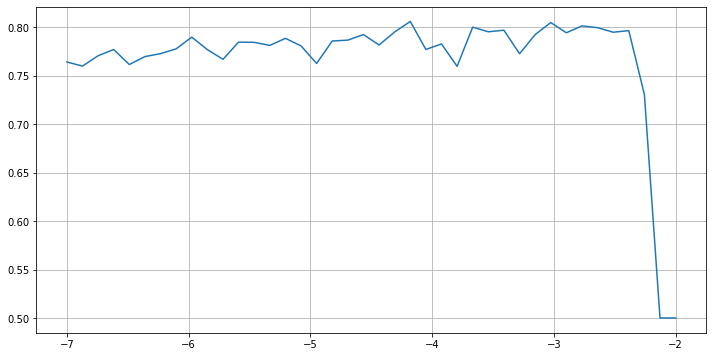

0.01530635496720326 -4.17948717948718


In [11]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.2
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

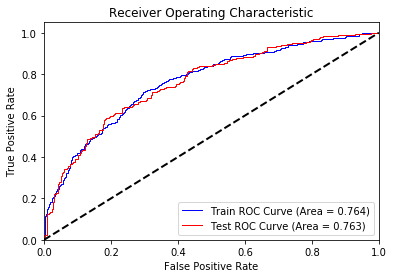

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

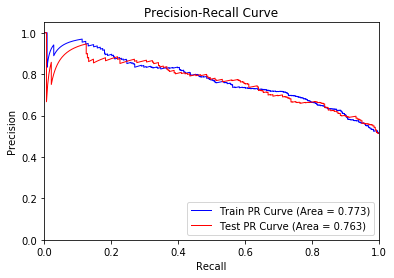

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 219


,HIF,Beta,Cluster
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.972297,10
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.767975,10
117,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN ESI_0080_HE,0.617611,10
177,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN ESI_00...,0.599117,10
118,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN STROMA_HE,0.560104,10
...,...,...,...
190,COUNT PROP [CANCER CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,-0.126722,15
533,REGION PROPERTIES: STANDARD DEVIATION OF EXTENTS OF SIGNIFICANT REGIONS OF NECROSIS_HE,-0.201815,20
192,COUNT PROP [CANCER CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,-0.231540,15
267,COUNT PROP [[LYMPHOCYTE CELLS] OVER [CANCER CELLS]] IN [TUMOR]_HE,-0.350617,10


### Outer Loop 2

In [13]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(1081, 607) (1081,)
(540, 607) (540,)


In [14]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.753735197782817, 0.7469560972537164, 0.7529698916603678, 0.7661958301839256, 0.766669816074578, 0.7853190350214161, 0.7611504787100025, 0.7482867220962459, 0.7598781179138321, 0.791156462585034, 0.769176744771983, 0.7864386495338876, 0.790336041824137, 0.7553744646006552, 0.785937893675989, 0.8041792642983119, 0.7730017006802721, 0.7293335852859663, 0.7852812421264802, 0.7899045729402872, 0.7318373645754598, 0.733133345930965, 0.8043587805492567, 0.7995275888133031, 0.7706191735953641, 0.7744047619047618, 0.7558279793398841, 0.76362748803225, 0.780306752330562, 0.786679579239103]


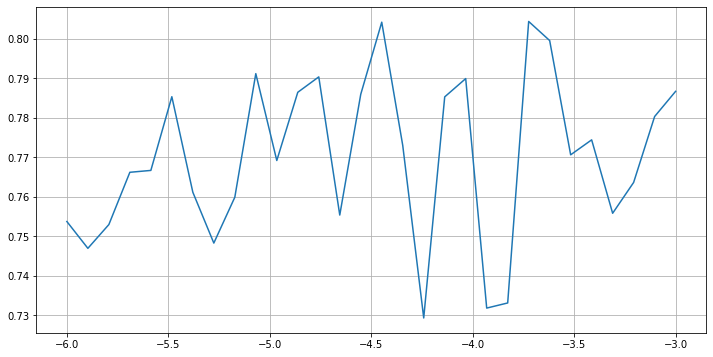

0.02413389654491333 -3.724137931034482


In [25]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.2
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

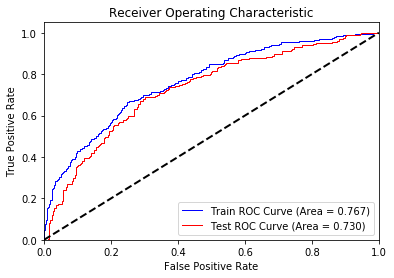

In [16]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

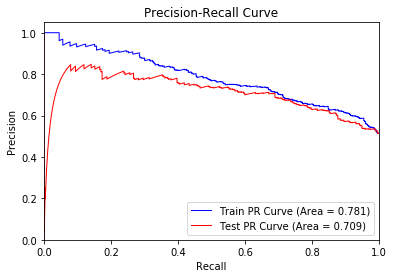

In [17]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 130


,HIF,Beta,Cluster
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.948862,10
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.721950,10
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.645676,10
178,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN STROMA_HE,0.629691,10
177,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN ESI_00...,0.564578,10
...,...,...,...
545,REGION PROPERTIES: TOTAL CONVEX AREA (MM2) OF TUMOR_HE,-0.080950,1
147,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF PLASMA IN TUMOR_HE,-0.083097,1
199,COUNT PROP [CANCER CELLS] IN [[TUMOR] OVER [STROMA]]_HE,-0.128490,15
189,COUNT PROP [CANCER CELLS] IN [[EPITHELIAL] OVER [STROMA]]_HE,-0.128490,15


### Outer Loop 3

In [19]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(1081, 607) (1081,)
(540, 607) (540,)


In [36]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7695908919123207, 0.7736300075585791, 0.7584309649785841, 0.7788926681783825, 0.7810452884857646, 0.7951609347442681, 0.7814058956916099, 0.7938492063492063, 0.8017983119173596, 0.7950884983623079, 0.7855048500881834, 0.8010188334593098, 0.8135644998740237, 0.8006109851347947, 0.7932571176618797, 0.7932697152935249, 0.7799004787100026, 0.8087002393550012, 0.7968316956412195, 0.7683374275636181, 0.7136967750062988, 0.7557964852607709, 0.7712742504409171, 0.7872858402620307, 0.7923626858150666, 0.7974521289997482, 0.7816436759889142, 0.7923185941043084, 0.7867173721340388, 0.7918792517006803]


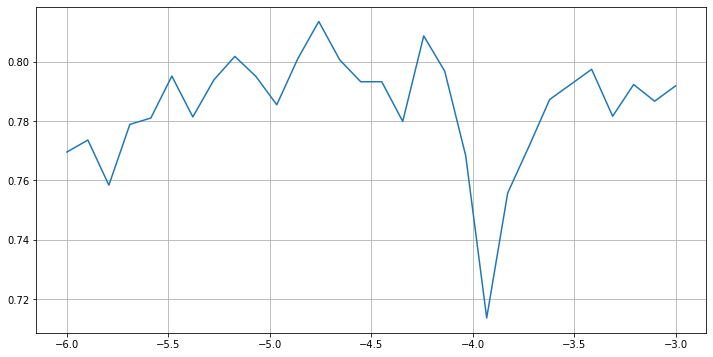

0.008577432182920498 -4.758620689655173


In [38]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.2
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

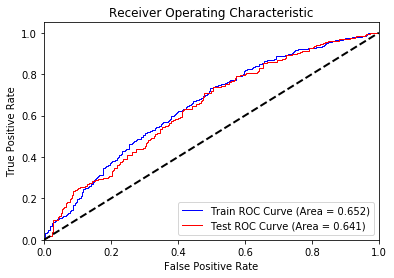

In [21]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

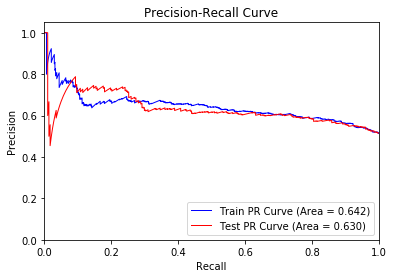

In [22]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 235


,HIF,Beta,Cluster
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.928578,10
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.911843,10
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.877725,10
57,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.722480,10
177,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN ESI_00...,0.686881,10
...,...,...,...
190,COUNT PROP [CANCER CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,-0.104970,15
192,COUNT PROP [CANCER CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,-0.146468,15
267,COUNT PROP [[LYMPHOCYTE CELLS] OVER [CANCER CELLS]] IN [TUMOR]_HE,-0.153292,10
395,DENSITY RATIO [[LYMPHOCYTE CELLS] OVER [CANCER CELLS]] IN [TUMOR]_HE,-0.153305,10


## Compute Ensemble Model

In [24]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.767975,0.948862,0.928578,10,0.881805
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.972297,0.645676,0.877725,10,0.831900
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.370486,0.721950,0.911843,10,0.668093
177,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN ESI_00...,0.599117,0.564578,0.686881,10,0.616859
117,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN ESI_0080_HE,0.617611,0.510641,0.566093,10,0.564782
...,...,...,...,...,...,...
190,COUNT PROP [CANCER CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,-0.126722,-0.069930,-0.104970,15,-0.100541
267,COUNT PROP [[LYMPHOCYTE CELLS] OVER [CANCER CELLS]] IN [TUMOR]_HE,-0.350617,0.000000,-0.153292,10,-0.167970
395,DENSITY RATIO [[LYMPHOCYTE CELLS] OVER [CANCER CELLS]] IN [TUMOR]_HE,-0.350618,0.000000,-0.153305,10,-0.167974
192,COUNT PROP [CANCER CELLS] IN [[ESI_0080] OVER [STROMA]]_HE,-0.231540,-0.196642,-0.146468,15,-0.191550


## Compute Final Train / Test Metrics

In [25]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.7637335108646416, 0.7670331928887062, 0.6516459425204671]
0.7274708820912718 0.053633248835972994


In [26]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.7625488962442215, 0.7303125557645056, 0.6412128865767114]
0.7113581128618128 0.05131640406875828


In [27]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.7728617657731729, 0.7813580969219689, 0.6418696095942951]
0.7320298240964789 0.06384718798327434


In [28]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.7632469194510911, 0.7087498093518854, 0.63043755660617]
0.7008114284697156 0.05450899089808507


## Evaluate Hold-Out Set

In [29]:
holdout_df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/pancancer.CTLA4.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE,joined.CTLA4_data
0,34.327408,81.342520,0.551184,62.415296,96.742704,0.354832,0.840813,0.645168,6633.257717,7130.446085,...,25000,1813,4109,7559,9372,1564,2336,2231,3795,0
1,18.961888,32.686732,6.767424,46.949360,65.911248,0.287688,0.495920,0.712312,5611.085772,6026.546207,...,160321,4956,12171,33449,38405,1385,5787,12023,13408,1
2,2.042160,2.735584,1.230176,7.568592,9.610752,0.212487,0.284638,0.787513,3935.741179,5306.740189,...,28523,413,1643,6123,6536,849,2863,8027,8876,1
3,67.331360,79.770572,0.214880,26.367440,93.698800,0.718594,0.851351,0.281406,7514.344122,7332.800369,...,26272,3188,4986,4670,7858,1266,1532,634,1900,0
4,24.716784,34.905768,7.369856,42.780144,67.496928,0.366191,0.517146,0.633809,5589.983127,6240.323681,...,126871,3673,12495,38551,42224,2081,8924,20944,23025,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,42.810968,71.876072,71.635612,89.004812,131.815780,0.324779,0.545277,0.675221,5849.430848,5578.271804,...,123464,6581,33044,80904,87485,1912,28761,99357,101269,1
515,47.872360,35.150752,10.031736,22.948752,70.821112,0.675962,0.496332,0.324038,6923.732594,5998.358443,...,20949,6118,10883,11042,17160,902,3880,5740,6642,0
516,20.681632,48.952788,4.349976,58.916880,79.598512,0.259824,0.614996,0.740176,6355.898094,6468.830562,...,195558,10550,41797,96434,106984,3846,52270,78530,82376,1
517,107.337592,179.691200,79.234320,183.314796,290.652388,0.369299,0.618234,0.630701,6385.322963,6357.834926,...,496427,21633,73755,159376,181009,7270,79853,205016,212286,0


In [30]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,-0.264150,0.496603,-0.527760,0.404003,0.091180,-0.750348,1.328443,0.750348,0.460257,1.211129,...,-0.552670,-0.575289,-0.443024,-0.539589,-0.433317,-0.473025,-0.335674,-0.545109,-0.478115,-0.497430
1,-0.715446,-0.611950,-0.062141,-0.022081,-0.404560,-1.173195,-1.034066,1.173195,-1.020111,-0.661388,...,1.081526,0.885769,0.158537,0.081646,0.573655,0.547617,-0.380017,-0.344137,-0.202419,-0.236648
2,-1.212389,-1.294345,-0.476901,-1.107016,-1.309818,-1.646784,-2.481348,1.646784,-3.446439,-1.882376,...,-0.484143,-0.537252,-0.710979,-0.729612,-0.489169,-0.572723,-0.512800,-0.514419,-0.314927,-0.359592
3,0.705197,0.460788,-0.552950,-0.589110,0.042237,1.540488,1.400629,-1.540488,1.736296,1.554377,...,-0.677123,-0.561556,-0.179853,-0.472009,-0.545683,-0.526249,-0.409497,-0.591930,-0.523079,-0.548837
4,-0.546420,-0.561393,-0.017016,-0.136942,-0.379064,-0.678812,-0.888671,0.678812,-1.050673,-0.298763,...,0.642227,0.524610,-0.087025,0.106613,0.772094,0.681872,-0.207598,-0.161452,0.048754,0.024242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,-0.014983,0.280923,4.796722,1.136541,0.655122,-0.939612,-0.695976,0.939612,-0.674926,-1.421784,...,0.594345,0.487824,0.469557,1.690061,2.419383,2.273002,-0.249464,0.993770,2.256490,2.146844
515,0.133674,-0.555811,0.182368,-0.683295,-0.325614,1.272008,-1.031249,-1.272008,0.880939,-0.709202,...,-0.634772,-0.619028,0.380940,-0.017603,-0.297848,-0.199241,-0.499670,-0.455193,-0.379318,-0.420196
516,-0.664936,-0.241351,-0.243216,0.307622,-0.184482,-1.348671,-0.218398,1.348671,0.058569,0.088848,...,1.399180,1.266222,1.229211,2.364543,3.023411,2.958481,0.229644,2.362833,1.670101,1.634315
517,1.880206,2.737337,5.365893,3.734768,3.209063,-0.659241,-0.196219,0.659241,0.101183,-0.099432,...,4.907412,4.514698,3.350462,4.827137,5.471494,5.560796,1.077868,3.969148,5.231344,5.158513


In [31]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

265


In [32]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [33]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

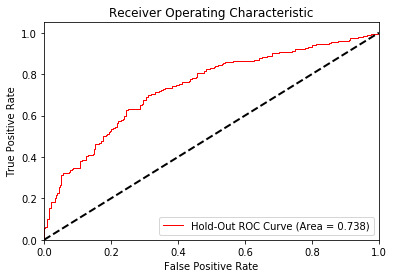

In [34]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.738


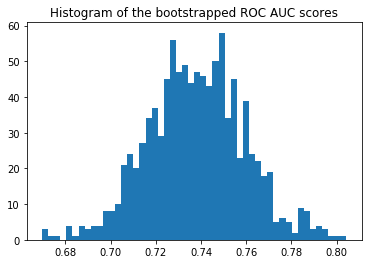

Confidence interval for the score: [0.697 - 0.785]


In [35]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

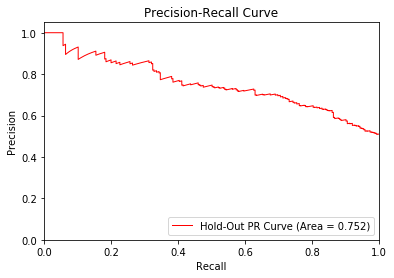

In [36]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.752


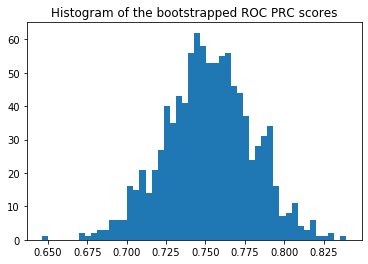

Confidence interval for the score: [0.699 - 0.807]


In [37]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))